In [20]:
import os
import sys
import string
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_laplace, label
from scipy.optimize import linear_sum_assignment
from copy import deepcopy
import scipy.signal as sig
from typing import List, Dict, Tuple, Optional
import logging



## Пути сохранений

In [21]:
PTW = "ptw/"   #Папка с исходниками с камеры
NUM_ARRAY = "num_py_convert"  #Папка с массивами np.array
VIDEO_TERM = "video_term_mp4"  # Папка для сохранения видео термограмм

## Функция получение np.array из .ptw

In [22]:
#НАСТРОЙКИ ПУТЕЙ


#ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
def mybyte(byte_data):
    return ord(byte_data) if sys.version_info[0] < 3 else byte_data

def myint(byte_data):
    return int.from_bytes(byte_data, byteorder='little')

def mylong(byte_data):
    return int.from_bytes(byte_data, byteorder='little')

def myfloat(byte_data):
    return np.frombuffer(byte_data, dtype=np.float32)[0]

def mydouble(byte_data):
    return np.frombuffer(byte_data, dtype=np.float64)[0]

def myRGB(byte_data):
    return [ord(byte_data[i]) if sys.version_info[0] < 3 else byte_data[i] for i in range(3)]

def terminateStrOnZero(byte_data):
    zero_index = byte_data.find(b'\x00')
    return byte_data[:zero_index] if zero_index != -1 else byte_data

def safe_decode_strip(byte_data):
    s = terminateStrOnZero(byte_data).decode('utf-8', errors='ignore')
    return s.rstrip(s[-1]) if s else ''

class PTWFrameInfo:
    pass

# ЧТЕНИЕ ЗАГОЛОВКА
def readPTWHeader(ptwfilename):
    Header = PTWFrameInfo()
    Header.FileName = ptwfilename
    with open(ptwfilename,'rb') as fid:
        headerinfo = fid.read(16)
        MainHeaderSize = mylong(headerinfo[11:15])
        fid.seek(0)
        headerinfo = fid.read(MainHeaderSize)

    Header.h_Signature = headerinfo[0:3].decode('utf-8') if sys.version_info[0]>2 else headerinfo[0:3]
    Header.h_format = 'cedip' if Header.h_Signature=='CED' else 'agema'
    Header.h_unit = 'dl' if Header.h_format=='cedip' else None
    Header.h_Version = headerinfo[5:10].decode('utf-8', errors='ignore') if sys.version_info[0]>2 else headerinfo[5:10]
    if not Header.h_Version[-1] in string.printable:
        Header.h_Version = Header.h_Version[:-1]

    Header.h_MainHeaderSize = mylong(headerinfo[11:15])
    Header.h_FrameHeaderSize = mylong(headerinfo[15:19])
    Header.h_SizeOfOneFrameAndHeader = mylong(headerinfo[19:23])
    Header.h_SizeOfOneFrame = mylong(headerinfo[23:27])
    Header.h_NumberOfFieldInFile = mylong(headerinfo[27:31])

    # размеры кадра
    Header.h_PixelsPerLine = myint(headerinfo[377:379])
    Header.h_LinesPerField = myint(headerinfo[379:381])
    Header.h_Rows = Header.h_LinesPerField if Header.h_LinesPerField>0 else 128
    Header.h_Cols = Header.h_PixelsPerLine if Header.h_PixelsPerLine>0 else 128
    Header.h_lastframe = Header.h_NumberOfFieldInFile
    Header.h_FrameSize = Header.h_FrameHeaderSize + Header.h_Rows * Header.h_Cols * 2

    # проверка lockin
    with open(ptwfilename,'rb') as fid:
        fid.seek(Header.h_MainHeaderSize + Header.h_FrameHeaderSize)
        firstline = fid.read(Header.h_Cols)
        if len(firstline)>=4 and firstline[1:4]==bytes([0,0,0]):
            Header.h_Lockin=1
            Header.h_Rows -= 1
            print('* LOCKIN')
        else:
            Header.h_Lockin=0
    return Header

# ========== ЧТЕНИЕ КАДРА ==========
def getPTWFrame(header, frameNumber):
    with open(header.FileName,'rb') as fid:
        frame_pos = header.h_MainHeaderSize + (frameNumber-1)*header.h_SizeOfOneFrameAndHeader + header.h_FrameHeaderSize
        fid.seek(frame_pos)
        frame_bytes = fid.read(header.h_SizeOfOneFrame)
        frame_length = len(frame_bytes)//2
        # корректировка rows и cols под реальный размер
        rows = header.h_Rows
        cols = header.h_Cols
        if rows*cols != frame_length:
            cols = 320
            rows = frame_length // cols
        data = np.frombuffer(frame_bytes, dtype=np.uint16).reshape(rows, cols)
    return data, header

# ========== ЧТЕНИЕ ВСЕХ КАДРОВ ==========
def getPTWFrames(header, loadFrames=[]):
    fheaders = []
    npFrames = np.asarray(loadFrames)
    if np.any(npFrames<1) or np.any(npFrames>header.h_lastframe):
        print(f"getPTWFrames Error: frame out of range 1-{header.h_lastframe}")
        return np.asarray([0]), None

    all_frames = []
    for frame in loadFrames:
        data, headerx = getPTWFrame(header, frame)
        all_frames.append(data)
        fheaders.append(headerx)
    return np.array(all_frames), fheaders

## Получение np.array из .ptw

In [23]:
if not os.path.exists(NUM_ARRAY):
    os.makedirs(NUM_ARRAY)

ptws = [f for f in os.listdir(PTW) if f.endswith('.ptw')]
print(f"Найдено {len(ptws)} PTW файлов для обработки")
print(f"Входная папка: {PTW}")
print(f"Выходная папка: {NUM_ARRAY}")

for ptw in tqdm(ptws, total=len(ptws)):
    try:
        header = readPTWHeader(os.path.join(PTW, ptw))
        # берем только нечётные кадры: 1,3,5,...
        odd_frames = range(1, header.h_lastframe+1, 2)
        frames = getPTWFrames(header, odd_frames)[0]
        output_path = os.path.join(NUM_ARRAY, f"therm_{ptw.replace('.ptw','')}.npy")
        np.save(output_path, frames.astype(np.int16))
    except Exception as e:
        print(f"Ошибка при обработке файла {ptw}: {str(e)}")
        continue


Найдено 2 PTW файлов для обработки
Входная папка: ptw/
Выходная папка: num_py_convert


100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


## Преобразование np.array в mp4

In [24]:
fps = 25

# Создаем папку для видео, если не существует
if not os.path.exists(VIDEO_TERM):
    os.makedirs(VIDEO_TERM)

# --- Функция сохранения видео ---
def save_video_from_frames(frames, out_path, fps=25):
    """Сохраняет numpy массив кадров в видео с глобальной нормализацией"""
    min_val = np.percentile(frames, 1)
    max_val = np.percentile(frames, 99)
    max_val = max(max_val, min_val + 1e-6)  # защита от деления на ноль

    frames_norm = []
    for f in frames:
        f_clip = np.clip(f, min_val, max_val)
        f_norm = ((f_clip - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        f_color = cv2.applyColorMap(f_norm, cv2.COLORMAP_JET)
        frames_norm.append(f_color)

    h, w, _ = frames_norm[0].shape
    writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    for f in frames_norm:
        writer.write(f)
    writer.release()
    print(f"Видео сохранено: {out_path}")

# --- Функция просмотра видео в реальном времени ---
def show_video_realtime(frames, fps=25):
    """Показывает термограмму в реальном времени с глобальной нормализацией"""
    delay = int(1000 / fps)
    total = len(frames)
    i = 0
    paused = False

    min_val = np.percentile(frames, 1)
    max_val = np.percentile(frames, 99)
    max_val = max(max_val, min_val + 1e-6)

    cv2.namedWindow("Thermogram", cv2.WINDOW_NORMAL)

    while True:
        try:
            if cv2.getWindowProperty("Thermogram", cv2.WND_PROP_VISIBLE) < 1:
                break
        except cv2.error:
            break

        f = frames[i]
        f_clip = np.clip(f, min_val, max_val)
        f_norm = ((f_clip - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        f_color = cv2.applyColorMap(f_norm, cv2.COLORMAP_JET)

        text = f"Frame {i+1}/{total} {'[PAUSE]' if paused else ''}"
        cv2.putText(f_color, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Thermogram", f_color)

        key = cv2.waitKey(0 if paused else delay) & 0xFF

        if key == 27:  # ESC
            break
        elif key == ord(' '):  # пробел — пауза
            paused = not paused
        elif key in [ord('a'), ord('A'), 81]:  # назад
            i = max(0, i - 1)
            paused = True
        elif key in [ord('d'), ord('D'), 83]:  # вперёд
            i = min(total - 1, i + 1)
            paused = True
        elif not paused:
            i = (i + 1) % total

    cv2.destroyAllWindows()

# --- Основной цикл обработки всех .npy файлов ---
npy_files = [f for f in os.listdir(NUM_ARRAY) if f.endswith('.npy')]
print(f"Найдено {len(npy_files)} .npy файлов для конвертации в видео.")

for npy_file in tqdm(npy_files, desc="Конвертация в видео"):
    try:
        frames = np.load(os.path.join(NUM_ARRAY, npy_file))
        print(f"Загружено {len(frames)} кадров из {npy_file}, размер одного кадра: {frames[0].shape}")

        # Сохраняем видео
        video_name = os.path.splitext(npy_file)[0] + ".mp4"
        out_path = os.path.join(VIDEO_TERM, video_name)
        save_video_from_frames(frames, out_path, fps=fps)

        # Просмотр видео
        # show_video_realtime(frames, fps=fps)

    except Exception as e:
        print(f"Ошибка при обработке {npy_file}: {e}")

print("Все видео обработаны!")


Найдено 2 .npy файлов для конвертации в видео.


Конвертация в видео:   0%|          | 0/2 [00:00<?, ?it/s]

Загружено 750 кадров из therm_8.npy, размер одного кадра: (128, 320)


Конвертация в видео:  50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

Видео сохранено: video_term_mp4/therm_8.mp4
Загружено 1500 кадров из therm_43.npy, размер одного кадра: (128, 320)


Конвертация в видео: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]

Видео сохранено: video_term_mp4/therm_43.mp4
Все видео обработаны!


## Функция запуска

In [25]:
def play_videos_from_folder(folder_path, fps=25):
    """
    Проигрывает все видео в указанной папке по одному.
    Управление:
        ESC - выйти
        ПРОБЕЛ - пауза/воспроизведение
        A/LEFT - назад (кадр)
        D/RIGHT - вперед (кадр)
        N - следующее видео
        Закрытие окна крестиком - выход из функции
    """
    video_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp4')])
    if not video_files:
        print("В папке нет видео.")
        return

    for vid_file in video_files:
        video_path = os.path.join(folder_path, vid_file)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Не удалось открыть видео: {vid_file}")
            continue

        print(f"Воспроизведение: {vid_file}")
        paused = False
        frame_index = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        cv2.namedWindow("Video Player", cv2.WINDOW_NORMAL)

        while True:
            # Проверка, закрыто ли окно крестиком
            try:
                if cv2.getWindowProperty("Video Player", cv2.WND_PROP_VISIBLE) < 1:
                    cap.release()
                    cv2.destroyAllWindows()
                    return
            except cv2.error:
                cap.release()
                cv2.destroyAllWindows()
                return

            if not paused:
                ret, frame = cap.read()
                if not ret:
                    break
                frame_index += 1
            else:
                # Если пауза, остаёмся на текущем кадре
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                ret, frame = cap.read()
                if not ret:
                    break

            if frame is None:
                break

            text = f"{vid_file}  Frame {frame_index}/{total_frames} {'[PAUSE]' if paused else ''}"
            cv2.putText(frame, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow("Video Player", frame)

            key = cv2.waitKey(int(1000/fps)) & 0xFF

            if key == 27:  # ESC
                cap.release()
                cv2.destroyAllWindows()
                return
            elif key == ord(' '):  # пробел — пауза/воспроизведение
                paused = not paused
            elif key in [ord('a'), ord('A'), 81]:  # назад
                frame_index = max(0, frame_index - 1)
                paused = True
            elif key in [ord('d'), ord('D'), 83]:  # вперед
                frame_index = min(total_frames - 1, frame_index + 1)
                paused = True
            elif key in [ord('n'), ord('N')]:  # следующее видео
                break

        cap.release()

    cv2.destroyAllWindows()
    print("Все видео воспроизведены.")


## Запуск видео

In [26]:
# play_videos_from_folder("video_term_mp4", fps=25)


# Вытаскивем признаки из видео (на самом деле из последовательности массивов)

## min_loc_LoG

In [27]:
def min_loc_LoG(image: np.ndarray, sigma: float = 2.0):
    """
    Находит минимум (яркую точку) на изображении через фильтр Лапласа-Гаусса (LoG).
    Используется для поиска горячих точек (всплесков температуры).
    """
    log = gaussian_laplace(image, sigma=sigma)
    min_val = np.min(log)
    min_loc = np.unravel_index(np.argmin(log), log.shape)
    return min_loc, min_val

## Детекция брызг

In [28]:
def detect_spatters(frame: np.ndarray, spat_thr_val: float = 95, min_area: int = 3):
    """
    Детектирует брызги (spatters) — локальные горячие точки.
    spat_thr_val — порог в процентах (0–100): чем ниже, тем чувствительнее.
    Возвращает список центров и радиусов для кружков, 
    исключая самый большой брызг.ф
    """
    # Нормализация и вычисление порога
    norm = cv2.normalize(frame.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
    thresh_val = np.percentile(norm, spat_thr_val)

    # Бинаризация и морфологическая обработка
    mask = (norm > thresh_val).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # Метки связных областей
    labeled, n = label(mask)

    spatters = []
    for k in range(1, n + 1):
        ys, xs = np.where(labeled == k)
        if len(xs) >= min_area:
            cx, cy = int(np.mean(xs)), int(np.mean(ys))
            radii = np.sqrt((xs - cx)**2 + (ys - cy)**2)
            radius = int(np.max(radii)) + 2  # чуть больше радиуса области
            spatters.append((cx, cy, radius))

    # Удаляем самый большой брызг по радиусу
    if spatters:
        max_idx = np.argmax([r for _, _, r in spatters])
        spatters.pop(max_idx)

    return spatters


## Зона сварки

In [29]:
def detect_welding_zone(frame: np.ndarray, blur_ksize: int = 15, zone_thr_val: float = 70):
    """
    Определяет основную зону сварки — крупную яркую область.
    zone_thr_val — порог в процентах (0–100): чем меньше, тем больше зона.
    Возвращает бинарную маску (1 — зона сварки).
    """
    # Размываем для подавления мелких всплесков
    blurred = cv2.GaussianBlur(frame.astype(np.float32), (blur_ksize, blur_ksize), 0)
    norm = cv2.normalize(blurred, None, 0, 1, cv2.NORM_MINMAX)
    thresh_val = np.percentile(norm, zone_thr_val)

    # Бинаризация
    _, mask = cv2.threshold(norm, thresh_val, 1, cv2.THRESH_BINARY)
    mask = mask.astype(np.uint8)

    # Находим компоненты и оставляем только самую большую
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest).astype(np.uint8)
    return mask

## Пример использования

Найдено всплесков: 4


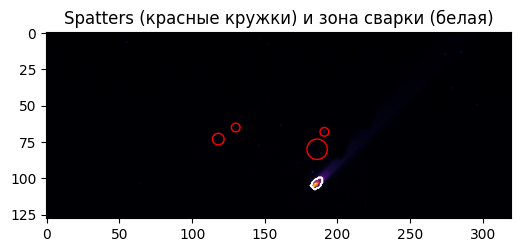

In [30]:
# === Пример использования ===
frames = np.load("num_py_convert/therm_8.npy")
frame = frames[520]  # примерный кадр

spatters = detect_spatters(frame, spat_thr_val=95, min_area=2)
weld_zone = detect_welding_zone(frame, zone_thr_val=99.9)

print("Найдено всплесков:", len(spatters))

# Визуализация
plt.figure(figsize=(6, 6))
plt.imshow(frame, cmap='inferno')

ax = plt.gca()
# Рисуем красные кружки вокруг каждого брызга
for cx, cy, r in spatters:
    circle = patches.Circle((cx, cy), r, edgecolor='red', facecolor='none', linewidth=1)
    ax.add_patch(circle)

# Контур зоны сварки
plt.contour(weld_zone, colors='white', linewidths=0.5)
plt.title("Spatters (красные кружки) и зона сварки (белая)")
plt.show()

## Плохо детектится разбираемся в проекте дальше

In [31]:
def frame_to_rgb_inferno(frame):
    """
    Преобразует 2D термограмму в RGB с cmap='inferno'
    """
    norm_frame = frame.astype(np.float32)
    norm_frame -= norm_frame.min()
    norm_frame /= (norm_frame.max() + 1e-6)
    norm_frame_uint8 = (norm_frame*255).astype(np.uint8)
    cmap = plt.get_cmap('inferno')
    colored = cmap(norm_frame_uint8)[:, :, :3]  # убираем альфа-канал
    rgb_frame = (colored*255).astype(np.uint8)
    return cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)  # OpenCV использует BGR

def show_video_cv2(frames, spat_thr_val=95, zone_thr_val=99.9, fps=10):
    total = len(frames)
    i = 0
    paused = False
    delay = int(1000/fps)

    cv2.namedWindow("Thermogram", cv2.WINDOW_NORMAL)

    while True:
        # проверка, закрыто ли окно
        try:
            if cv2.getWindowProperty("Thermogram", cv2.WND_PROP_VISIBLE) < 1:
                break
        except cv2.error:
            break

        frame = frames[i]
        rgb_frame = frame_to_rgb_inferno(frame)

        # брызги
        spatters = detect_spatters(frame, spat_thr_val=spat_thr_val, min_area=2)
        for cx, cy, r in spatters:
            cv2.circle(rgb_frame, (cx, cy), r, (0, 0, 255), 1)

        # зона сварки
        weld_zone = detect_welding_zone(frame, zone_thr_val=zone_thr_val)
        contours, _ = cv2.findContours(weld_zone.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(rgb_frame, contours, -1, (255, 255, 255), 1)

        # текст
        text = f"Frame {i+1}/{total} {'[PAUSE]' if paused else ''}"
        cv2.putText(rgb_frame, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        cv2.imshow("Thermogram", rgb_frame)

        key = cv2.waitKey(0 if paused else delay) & 0xFF
        if key == 27:  # ESC
            break
        elif key == ord(' '):
            paused = not paused
        elif key in [ord('a'), ord('A'), 81]:  # назад
            i = max(0, i-1)
            paused = True
        elif key in [ord('d'), ord('D'), 83]:  # вперед
            i = min(total-1, i+1)
            paused = True
        elif not paused:
            i = (i+1) % total

    cv2.destroyAllWindows()
    return  # завершает выполнение функции и ячейки

In [32]:

# # === Использование ===
# frames = np.load("num_py_convert/therm_8.npy")
# show_video_cv2(frames, spat_thr_val=90, zone_thr_val=99.9)

# Нормальная функция обработки

## Конфигурационные параметры

In [33]:

class Config:
    # Параметры фильтрации зоны сварки
    WELDING_ZONE_THRESHOLD = 85
    WELDING_ZONE_MIN_AREA = 5
    
    # Параметры детектирования брызг
    SPATTER_MAX_SIZE = 10
    SPATTER_FILTER_RADIUS = 10
    
    # Параметры удаления артефактов
    REFLECTION_DX, REFLECTION_DY, REFLECTION_RADIUS = -80, -10, 20
    TRACE_DX, TRACE_DY, TRACE_RADIUS = 40, -40, 15
    
    # Параметры LoG фильтра
    LOG_KERNEL_SIZE = 9
    LOG_SIGMA = 1.8
    LOG_THRESHOLD = 1.8
    
    # Параметры трекера
    MAX_TRACK_DISTANCE = 17
    MAX_ANGLE_DEVIATION = 15  # градусов

## Детектор брызг металла на термограммах

In [34]:
class SpatterDetector:
    """Детектор брызг металла на термограммах"""
    
    @staticmethod
    def create_log_filters(k_size: int, sigma: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Создает 4 фильтра Лапласиана Гауссиана для разных направлений
        """
        x = np.arange(k_size).reshape(1, k_size)
        y = np.arange(k_size).reshape(k_size, 1)
        
        # Восточный фильтр (positive X)
        fE = (1 - (x**2) / (sigma**2)) * np.exp(-(x**2) / (2 * sigma**2))
        fE[fE > 0] /= fE[fE > 0].sum()
        fE[fE < 0] /= -fE[fE < 0].sum()
        
        # Южный фильтр (positive Y)
        fS = (1 - (y**2) / (sigma**2)) * np.exp(-(y**2) / (2 * sigma**2))
        fS[fS > 0] /= fS[fS > 0].sum()
        fS[fS < 0] /= -fS[fS < 0].sum()
        
        # Западный фильтр (negative X)
        x_west = -np.fliplr(x)
        fW = (1 - (x_west**2) / (sigma**2)) * np.exp(-(x_west**2) / (2 * sigma**2))
        fW[fW > 0] /= fW[fW > 0].sum()
        fW[fW < 0] /= -fW[fW < 0].sum()
        
        # Северный фильтр (negative Y)
        y_north = -np.flipud(y)
        fN = (1 - (y_north**2) / (sigma**2)) * np.exp(-(y_north**2) / (2 * sigma**2))
        fN[fN > 0] /= fN[fN > 0].sum()
        fN[fN < 0] /= -fN[fN < 0].sum()
        
        return fE, fS, fW, fN
    
    @staticmethod
    def min_loc_log(image: np.ndarray, k_size: int = Config.LOG_KERNEL_SIZE, 
                   sigma: float = Config.LOG_SIGMA) -> np.ndarray:
        """
        Min-local-LoG фильтрация для детектирования мелких целей
        """
        fE, fS, fW, fN = SpatterDetector.create_log_filters(k_size, sigma)
        
        def shift_image(img: np.ndarray, dx: int, dy: int) -> np.ndarray:
            """Сдвиг изображения на указанные координаты"""
            shift_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
            return cv2.warpAffine(img, shift_matrix, (img.shape[1], img.shape[0]))
        
        # Применение фильтров со сдвигами
        I_east = sig.convolve2d(shift_image(image, 4, 0), fE, mode="same")
        I_south = sig.convolve2d(shift_image(image, 0, 4), fS, mode="same")
        I_west = sig.convolve2d(shift_image(image, -4, 0), fW, mode="same")
        I_north = sig.convolve2d(shift_image(image, 0, -4), fN, mode="same")
        
        # Объединение результатов
        filtered_stack = np.dstack((I_east, I_south, I_west, I_north))
        feature_map = np.min(filtered_stack, axis=2)
        
        return feature_map
    
    @staticmethod
    def detect_spatters(frame: np.ndarray) -> np.ndarray:
        """
        Обнаружение брызг на термограмме
        Возвращает массив брызг в формате [center_x, center_y, width, height]
        """
        # Применение LoG фильтра
        filtered = SpatterDetector.min_loc_log(frame)
        
        # Бинаризация
        binary = ((filtered > Config.LOG_THRESHOLD) * 255).astype(np.uint8)
        
        # Поиск контуров
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return np.array([])
        
        # Преобразование контуров в bounding boxes
        spatters = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            
            # Фильтрация по размеру
            if w < Config.SPATTER_MAX_SIZE and h < Config.SPATTER_MAX_SIZE:
                center_x = x + w / 2
                center_y = y + h / 2
                spatters.append([center_x, center_y, w, h])
        
        return np.array(spatters)
    
    @staticmethod
    def detect_welding_zone(frame: np.ndarray) -> Tuple[np.ndarray, Tuple]:
        """
        Обнаружение зоны сварки
        Возвращает bounding box и параметры эллипса
        """
        # Бинаризация для поиска яркой зоны сварки
        binary = ((frame > Config.WELDING_ZONE_THRESHOLD) * 255).astype(np.uint8)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            raise ValueError("Не удалось обнаружить зону сварки")
        
        # Поиск наибольшего контура
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Получение bounding box
        x, y, w, h = cv2.boundingRect(largest_contour)
        center_x = x + w / 2
        center_y = y + h / 2
        
        # Проверка площади
        area = w * h
        if area <= Config.WELDING_ZONE_MIN_AREA:
            raise ValueError("Обнаруженная зона сварки слишком мала")
        
        bounding_box = np.array([center_x, center_y, w, h])
        ellipse = cv2.fitEllipse(largest_contour)
        
        return bounding_box, ellipse
    
    @staticmethod
    def filter_spatters(spatters: np.ndarray, welding_center: np.ndarray, 
                       radius: float = Config.SPATTER_FILTER_RADIUS) -> np.ndarray:
        """Фильтрация брызг по расстоянию от центра сварки"""
        if len(spatters) == 0:
            return spatters
        
        center_x, center_y = welding_center[:2]
        distances = (spatters[:, 0] - center_x)**2 + (spatters[:, 1] - center_y)**2
        
        return spatters[distances > radius**2]
    
    @staticmethod
    def remove_artifacts(spatters: np.ndarray, welding_center: np.ndarray, 
                        dx: float, dy: float, radius: float) -> np.ndarray:
        """Удаление артефактов (отражений, следов)"""
        if len(spatters) == 0:
            return spatters
        
        center_x, center_y = welding_center[:2]
        artifact_x = center_x + dx
        artifact_y = center_y + dy
        
        distances = (spatters[:, 0] - artifact_x)**2 + (spatters[:, 1] - artifact_y)**2
        
        return spatters[distances > radius**2]


## Продвинутый трекер для отслеживания брызг

In [35]:
class AdvancedSpatterTracker:
    """
    Продвинутый трекер для отслеживания брызг металла
    Использует историю из нескольких кадров и анализ траекторий
    """
    
    def __init__(self, max_distance: float = Config.MAX_TRACK_DISTANCE, 
                 max_angle_deviation: float = Config.MAX_ANGLE_DEVIATION):
        self.max_distance = max_distance
        self.max_angle_deviation = max_angle_deviation
        
        self.tracks: Dict[int, List[np.ndarray]] = {}  # {track_id: [point1, point2, point3]}
        self.frame_history: List[np.ndarray] = []  # История точек за последние 3 кадра
        self.next_track_id = 0
        
        logging.info("Инициализирован продвинутый трекер брызг")
    
    @staticmethod
    def compute_angle(point1: np.ndarray, point2: np.ndarray, vertex: np.ndarray) -> float:
        """
        Вычисление угла между двумя точками относительно вершины
        """
        vector1 = point1[:2] - vertex[:2]
        vector2 = point2[:2] - vertex[:2]
        
        # Нормализация векторов
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            return 180.0
        
        cosine = np.dot(vector1, vector2) / (norm1 * norm2)
        cosine = np.clip(cosine, -1.0, 1.0)  # Защита от численных ошибок
        
        angle = np.degrees(np.arccos(cosine))
        return angle
    
    @staticmethod
    def compute_distances(point: np.ndarray, points_array: np.ndarray) -> np.ndarray:
        """Вычисление расстояний от точки до массива точек"""
        return np.sqrt(np.sum((points_array[:, :2] - point[:2])**2, axis=1))
    
    def _find_best_match(self, current_points: np.ndarray, previous_point1: np.ndarray, 
                        previous_point2: np.ndarray, used_indices: List[int]) -> Tuple[Optional[int], float, Optional[int], float]:
        """
        Поиск наилучшего соответствия для продолжения трека
        """
        distance_prev = np.linalg.norm(previous_point1[:2] - previous_point2[:2])
        
        best_match_idx = None
        best_angle_diff = 181.0
        
        closest_match_idx = None
        closest_distance = float('inf')
        
        for idx, point in enumerate(current_points):
            if idx in used_indices:
                continue
            
            # Вычисление расстояния
            distance_current = np.linalg.norm(point[:2] - previous_point2[:2])
            
            # Поиск ближайшей точки
            if distance_current < closest_distance:
                closest_distance = distance_current
                closest_match_idx = idx
            
            # Проверка условий для оптимального соответствия
            if distance_current > self.max_distance:
                continue
            
            # Проверка соотношения расстояний
            dist_ratio = min(distance_prev, distance_current) / max(distance_prev, distance_current)
            if dist_ratio < 0.5:
                continue
            
            # Проверка угла движения
            angle = self.compute_angle(previous_point1, point, previous_point2)
            angle_diff = abs(180 - angle)
            
            if angle_diff <= self.max_angle_deviation and angle_diff < best_angle_diff:
                best_angle_diff = angle_diff
                best_match_idx = idx
        
        return best_match_idx, best_angle_diff, closest_match_idx, closest_distance
    
    def update_existing_tracks(self, current_points: np.ndarray) -> List[int]:
        """
        Обновление существующих треков
        Возвращает список ID несовпавших треков
        """
        unmatched_track_ids = []
        used_point_indices = []
        
        for track_id, track_points in list(self.tracks.items()):
            if len(track_points) < 2:
                continue
                
            point1, point2 = track_points[-2], track_points[-1]
            
            best_match, _, closest_match, closest_dist = self._find_best_match(
                current_points, point1, point2, used_point_indices
            )
            
            if best_match is not None:
                # Обновление трека новой точкой
                self.tracks[track_id].append(current_points[best_match])
                if len(self.tracks[track_id]) > 3:  # Сохраняем только последние 3 точки
                    self.tracks[track_id].pop(0)
                used_point_indices.append(best_match)
                
            elif closest_match is not None and closest_dist < 2:
                # Использование ближайшей точки при малом расстоянии
                self.tracks[track_id].append(current_points[closest_match])
                if len(self.tracks[track_id]) > 3:
                    self.tracks[track_id].pop(0)
                used_point_indices.append(closest_match)
            else:
                # Трек не совпал
                unmatched_track_ids.append(track_id)
        
        # Удаление несовпавших треков
        for track_id in unmatched_track_ids:
            del self.tracks[track_id]
            
        return used_point_indices
    
    def create_new_tracks(self, current_points: np.ndarray, used_point_indices: List[int]) -> List[int]:
        """
        Создание новых треков из несопоставленных точек
        """
        new_tracks_created = 0
        used_previous_indices = []
        
        if len(self.frame_history) < 2:
            return used_point_indices
        
        points_prev_prev = self.frame_history[0]  # Кадр t-2
        points_prev = self.frame_history[1]       # Кадр t-1
        
        if len(points_prev_prev) == 0 or len(points_prev) == 0:
            return used_point_indices
        
        # Поиск новых треков по трем последовательным кадрам
        for idx1, point1 in enumerate(points_prev_prev):
            best_match_prev = None
            best_match_current = None
            best_angle = 181.0
            
            for idx2, point2 in enumerate(points_prev):
                if idx2 in used_previous_indices:
                    continue
                
                distance = np.linalg.norm(point1[:2] - point2[:2])
                if distance > self.max_distance:
                    continue
                
                best_match, best_angle_diff, _, _ = self._find_best_match(
                    current_points, point1, point2, used_point_indices
                )
                
                if best_match is not None and best_angle_diff < best_angle:
                    best_angle = best_angle_diff
                    best_match_prev = idx2
                    best_match_current = best_match
            
            if best_match_prev is not None and best_match_current is not None:
                # Создание нового трека
                new_track = [point1, points_prev[best_match_prev], current_points[best_match_current]]
                self.tracks[self.next_track_id] = new_track
                self.next_track_id += 1
                new_tracks_created += 1
                
                used_previous_indices.append(best_match_prev)
                used_point_indices.append(best_match_current)
        
        return used_point_indices
    
    def step(self, current_points: np.ndarray) -> Dict[int, List[np.ndarray]]:
        """
        Основной метод обработки нового кадра
        """
        if current_points is None or len(current_points) == 0:
            # Обновление истории кадров
            if len(self.frame_history) > 0:
                self.frame_history.pop(0)
            return self.tracks.copy()
        
        # Добавление текущих точек в историю
        self.frame_history.append(current_points)
        if len(self.frame_history) > 3:
            self.frame_history.pop(0)
        
        if len(self.frame_history) < 3:
            return self.tracks.copy()
        
        # Обновление существующих треков
        used_indices = self.update_existing_tracks(current_points)
        
        # Создание новых треков
        used_indices = self.create_new_tracks(current_points, used_indices)
        
        # Обновление истории кадров для следующей итерации
        unused_previous_points = []
        unused_current_points = []
        
        for idx, point in enumerate(self.frame_history[1]):  # Кадр t-1
            if idx not in used_indices:
                unused_previous_points.append(point)
                
        for idx, point in enumerate(current_points):  # Кадр t
            if idx not in used_indices:
                unused_current_points.append(point)
        
        self.frame_history = [unused_previous_points, unused_current_points]
        
        return self.tracks.copy()


class ThermogramProcessor:
    """
    Основной класс для обработки термограмм сварки
    """
    
    def __init__(self, config: Config = None):
        self.config = config or Config()
        self.detector = SpatterDetector()
        self.tracker = AdvancedSpatterTracker()
        
        logging.info("Инициализирован процессор термограмм")
    
    def preprocess_thermogram(self, thermal_data: np.ndarray) -> np.ndarray:
        """
        Предобработка термографических данных
        """
        # Нормализация температурных данных
        t_min = thermal_data.min()
        t_max = thermal_data.max()
        
        if t_max == t_min:
            return np.zeros_like(thermal_data, dtype=np.uint8)
        
        normalized = (thermal_data - t_min) / (t_max - t_min)
        normalized_uint8 = (normalized * 255).astype(np.uint8)
        
        return normalized_uint8
    
    def process_frame(self, frame: np.ndarray, thermal_frame: np.ndarray) -> Dict:
        """
        Обработка одного кадра термограммы
        """
        result = {
            'welding_zone': None,
            'spatters': np.array([]),
            'filtered_spatters': np.array([]),
            'tracks': {},
            'success': False
        }
        
        try:
            # Детектирование зоны сварки
            welding_zone, ellipse = self.detector.detect_welding_zone(frame)
            result['welding_zone'] = welding_zone
            result['ellipse'] = ellipse
            
            # Детектирование брызг
            spatters = self.detector.detect_spatters(frame)
            result['spatters'] = spatters
            
            if len(spatters) > 0:
                # Фильтрация брызг
                filtered_spatters = self.detector.filter_spatters(spatters, welding_zone)
                
                # Удаление артефактов
                filtered_spatters = self.detector.remove_artifacts(
                    filtered_spatters, welding_zone,
                    self.config.REFLECTION_DX, self.config.REFLECTION_DY, self.config.REFLECTION_RADIUS
                )
                
                filtered_spatters = self.detector.remove_artifacts(
                    filtered_spatters, welding_zone,
                    self.config.TRACE_DX, self.config.TRACE_DY, self.config.TRACE_RADIUS
                )
                
                result['filtered_spatters'] = filtered_spatters
                
                # Отслеживание брызг
                tracks = self.tracker.step(filtered_spatters)
                result['tracks'] = tracks
            
            result['success'] = True
            
        except Exception as e:
            logging.warning(f"Ошибка обработки кадра: {e}")
            result['success'] = False
        
        return result

    def frame_to_rgb_inferno(self, frame: np.ndarray) -> np.ndarray:
        """
        Преобразует 2D термограмму в RGB с cmap='inferno'
        """
        norm_frame = frame.astype(np.float32)
        norm_frame -= norm_frame.min()
        norm_frame /= (norm_frame.max() + 1e-6)
        norm_frame_uint8 = (norm_frame * 255).astype(np.uint8)
        cmap = plt.get_cmap('inferno')
        colored = cmap(norm_frame_uint8)[:, :, :3]  # убираем альфа-канал
        rgb_frame = (colored * 255).astype(np.uint8)
        return cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)  # OpenCV использует BGR
    
    def visualize_results(self, frame: np.ndarray, result: Dict, scale: int = 2) -> np.ndarray:
        """
        Визуализация результатов обработки с цветовой картой inferno
        """
        # Создание изображения с цветовой картой inferno
        rgb_frame = self.frame_to_rgb_inferno(frame)
        vis_image = cv2.resize(rgb_frame, (frame.shape[1] * scale, frame.shape[0] * scale))
        
        # Отрисовка зоны сварки
        if result['welding_zone'] is not None:
            center_x, center_y, w, h = result['welding_zone']
            # Отрисовка эллипса
            if 'ellipse' in result and result['ellipse'] is not None:
                ellipse_scaled = (
                    (int(center_x * scale), int(center_y * scale)),
                    (int(w * scale), int(h * scale)),
                    result['ellipse'][2]
                )
                cv2.ellipse(vis_image, ellipse_scaled, (0, 255, 0), 1)
            
            # Отрисовка радиуса фильтрации
            cv2.circle(vis_image, (int(center_x * scale), int(center_y * scale)), 
                      self.config.SPATTER_FILTER_RADIUS * scale, (130, 130, 130), 1)
        
        # Отрисовка брызг
        for spatter in result['filtered_spatters']:
            x, y, w, h = spatter
            cv2.circle(vis_image, (int(x * scale), int(y * scale)), 4, (0, 0, 255), 1)
        
        # Отрисовка треков
        for track_id, track_points in result['tracks'].items():
            if len(track_points) >= 2:
                points = []
                for point in track_points:
                    x, y, w, h = point
                    points.append((int(x * scale), int(y * scale)))
                points = np.array(points)
                
                # Отрисовка линий траектории
                for i in range(len(points) - 1):
                    cv2.line(vis_image, tuple(points[i]), tuple(points[i + 1]), 
                            (255, 255, 255), 1)
                
                # Отрисовка последней точки
                if len(points) > 0:
                    cv2.circle(vis_image, tuple(points[-1]), 4, (0, 0, 255), 1)
        
        return vis_image


## Класс для записи видео результатов

In [36]:
class VideoRecorder:
    """Класс для записи видео результатов"""
    
    def __init__(self, output_path: str, frame_size: Tuple[int, int], fps: int = 10):
        self.output_path = output_path
        self.frame_size = frame_size
        self.fps = fps
        self.writer = None
        
    def initialize(self):
        """Инициализация видеозаписи"""
        try:
            # Создаем папку если нужно
            os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
            
            # Инициализация VideoWriter с кодеком MP4V
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            self.writer = cv2.VideoWriter(self.output_path, fourcc, self.fps, self.frame_size)
            print(f"Видеозапись инициализирована: {self.output_path}")
            print(f"Размер кадра: {self.frame_size}, FPS: {self.fps}")
            return True
        except Exception as e:
            print(f"Ошибка инициализации видеозаписи: {e}")
            return False
    
    def write_frame(self, frame: np.ndarray):
        """Запись кадра в видео"""
        if self.writer is not None:
            self.writer.write(frame)
    
    def release(self):
        """Завершение записи видео"""
        if self.writer is not None:
            self.writer.release()
            print(f"Видео сохранено: {self.output_path}")

## Функция показа видео

In [39]:
def show_video_with_tracking(frames, fps=10):
    """
    Показ видео с трекингом брызг и удобным управлением
    """
    processor = ThermogramProcessor()
    total = len(frames)
    i = 0
    paused = False
    delay = int(1000 / fps)
    
    # Определяем размер для записи видео
    sample_result = processor.process_frame(processor.preprocess_thermogram(frames[0]), frames[0])
    sample_vis = processor.visualize_results(processor.preprocess_thermogram(frames[0]), sample_result)
    frame_height, frame_width = sample_vis.shape[:2]
    
    # Инициализация видеозаписи
    video_recorder = VideoRecorder(
        output_path="video_term_with_markup/spatter_tracking_video.mp4",
        frame_size=(frame_width, frame_height),
        fps=fps
    )
    video_recorder.initialize()
    
    cv2.namedWindow("Thermogram Analysis - Spatter Tracking", cv2.WINDOW_NORMAL)
    
    print("Управление:")
    print("  ESC или q - выход")
    print("  ПРОБЕЛ - пауза/продолжение")
    print("  A или ← - предыдущий кадр")
    print("  D или → - следующий кадр")
    
    while True:
        # проверка, закрыто ли окно
        try:
            if cv2.getWindowProperty("Thermogram Analysis - Spatter Tracking", cv2.WND_PROP_VISIBLE) < 1:
                break
        except cv2.error:
            break

        # Обработка текущего кадра
        frame = frames[i]
        processed_frame = processor.preprocess_thermogram(frame)
        result = processor.process_frame(processed_frame, frame)
        visualization = processor.visualize_results(processed_frame, result)
        
        # Запись кадра в видео
        video_recorder.write_frame(visualization)
        
        # Добавление текста с информацией
        text = f"Frame {i+1}/{total} {'[PAUSE]' if paused else ''}"
        cv2.putText(visualization, text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(visualization, f"Tracks: {len(result['tracks'])}", (10, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        cv2.putText(visualization, f"Spatters: {len(result['filtered_spatters'])}", (10, 75), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

        cv2.imshow("Thermogram Analysis - Spatter Tracking", visualization)

        # Обработка клавиш
        key = cv2.waitKey(0 if paused else delay) & 0xFF
        
        if key == 27 or key == ord('q'):  # ESC или q
            break
        elif key == ord(' '):  # ПРОБЕЛ
            paused = not paused
        elif key in [ord('a'), ord('A'), 81]:  # назад (A или стрелка влево)
            i = max(0, i - 1)
            paused = True
        elif key in [ord('d'), ord('D'), 83]:  # вперед (D или стрелка вправо)
            i = min(total - 1, i + 1)
            paused = True
        elif not paused:
            i = (i + 1) % total

    # Завершение записи видео
    video_recorder.release()
    cv2.destroyAllWindows()
    
    print(f"Обработка завершена. Видео сохранено: video_term_with_markup/spatter_tracking_video.mp4")
    print(f"Итоговая статистика:")
    print(f"  - Обработано кадров: {total}")
    print(f"  - Создано треков: {processor.tracker.next_track_id}")



## Запуск просмотра с трекингом и записью видео

In [40]:
# Загрузка термограмм
thermal_data = np.load('num_py_convert/therm_8.npy')
print(f"Загружены термограммы: {thermal_data.shape}")


# Запуск просмотра с трекингом и записью видео
show_video_with_tracking(thermal_data, fps=10)


Загружены термограммы: (750, 128, 320)
Видеозапись инициализирована: video_term_with_markup/spatter_tracking_video.mp4
Размер кадра: (640, 256), FPS: 10
Управление:
  ESC или q - выход
  ПРОБЕЛ - пауза/продолжение
  A или ← - предыдущий кадр
  D или → - следующий кадр


/tmp/ipykernel_50308/3303905182.py:74: RuntimeWarning: invalid value encountered in scalar divide
  dist_ratio = min(distance_prev, distance_current) / max(distance_prev, distance_current)


Видео сохранено: video_term_with_markup/spatter_tracking_video.mp4
Обработка завершена. Видео сохранено: video_term_with_markup/spatter_tracking_video.mp4
Итоговая статистика:
  - Обработано кадров: 750
  - Создано треков: 1345
